In [244]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import ShuffleSplit

path = Path('data/student_classification')
sns.set_style('whitegrid')
sns.set_context('paper')

### Dataset opening and basic examination

In [201]:
math_df = pd.read_csv(path/'student-mat.csv', delimiter=';')
port_df = pd.read_csv(path/'student-por.csv', delimiter=';')
math_df.shape,port_df.shape

((395, 33), (649, 33))

In [202]:
math_df.columns, port_df.columns

(Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
        'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
        'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
       dtype='object'),
 Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
        'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
        'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
       dtype='object'))

In [203]:
# note that columns in both datasets are the same
assert math_df.columns.all() == port_df.columns.all()

In [204]:
key_cols.extend(('G1','G2','G3'))


In [258]:
full_df = (pd.merge(math_df, port_df, on=["school","sex","age",
                             "address","famsize","Pstatus",
                             "Medu","Fedu","Mjob",
                             "Fjob","reason","nursery","internet"],
                   suffixes=('_m', '_p'))
          )
full_df.shape

(382, 53)

In [259]:
full_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian_m', 'traveltime_m', 'studytime_m',
       'failures_m', 'schoolsup_m', 'famsup_m', 'paid_m', 'activities_m',
       'nursery', 'higher_m', 'internet', 'romantic_m', 'famrel_m',
       'freetime_m', 'goout_m', 'Dalc_m', 'Walc_m', 'health_m', 'absences_m',
       'G1_m', 'G2_m', 'G3_m', 'guardian_p', 'traveltime_p', 'studytime_p',
       'failures_p', 'schoolsup_p', 'famsup_p', 'paid_p', 'activities_p',
       'higher_p', 'romantic_p', 'famrel_p', 'freetime_p', 'goout_p', 'Dalc_p',
       'Walc_p', 'health_p', 'absences_p', 'G1_p', 'G2_p', 'G3_p'],
      dtype='object')

In [225]:
# locating size of divergence from same student in a category
full_df.loc[full_df['freetime_m']==full_df['freetime_p']].shape

(371, 53)

<ipython-input-209-fa0b79ba575f>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  math_df.hist(ax=ax);


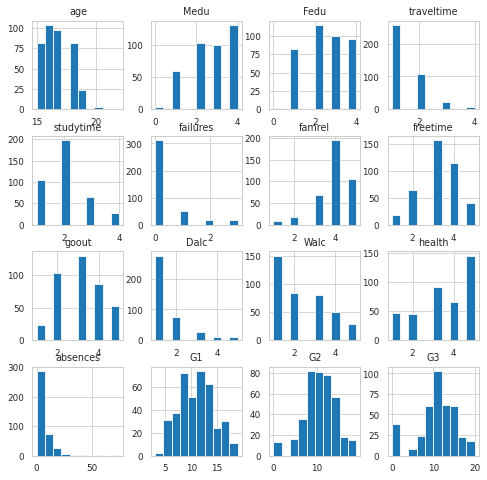

In [209]:
# looking at data distribution
fig, ax = plt.subplots(figsize=(8, 8))
math_df.hist(ax=ax);

<ipython-input-210-33d6d0bdd9e1>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  port_df.hist(ax=ax);


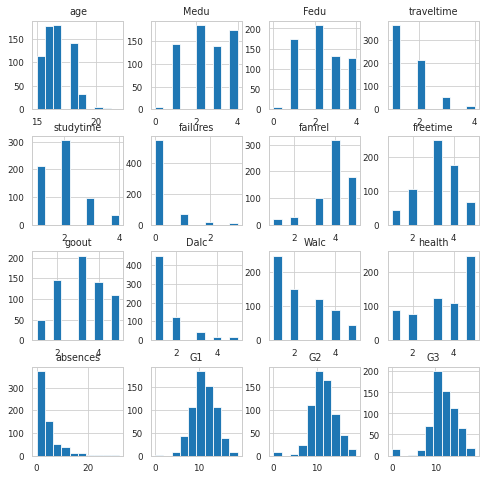

In [210]:
# looking at data distribution
fig, ax = plt.subplots(figsize=(8, 8))
port_df.hist(ax=ax);

Text(0.5, 1.0, 'Grade Density')

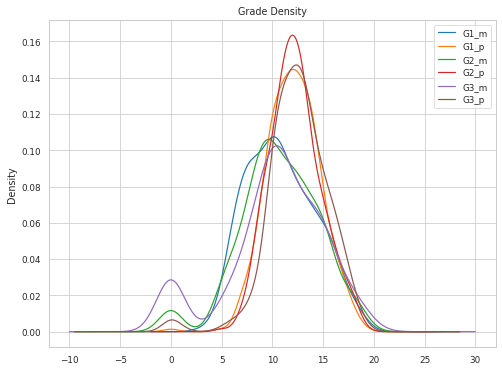

In [211]:
sns.set_style('whitegrid')
sns.set_context('paper')
# looking at grade comparision between same student
grade_cols = ['G1_m','G1_p','G2_m',
              'G2_p','G3_m','G3_p']
fig,ax = plt.subplots(figsize=(8,6))
full_df[grade_cols].plot.kde(ax=ax)
ax.set_title('Grade Density')

In [212]:
# basic description of the grades
full_df[grade_cols].describe()

,G1_m,G1_p,G2_m,G2_p,G3_m,G3_p
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,10.861257,12.112565,10.712042,12.238220,10.387435,12.515707
std,3.349167,2.556531,3.832560,2.468341,4.687242,2.945438
min,3.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,8.000000,10.000000,8.250000,11.000000,8.000000,11.000000
50%,10.500000,12.000000,11.000000,12.000000,11.000000,13.000000
75%,13.000000,14.000000,13.000000,14.000000,14.000000,14.000000
max,19.000000,19.000000,19.000000,19.000000,20.000000,19.000000


In [213]:
full_df.dtypes

school          object
sex             object
age              int64
address         object
famsize         object
Pstatus         object
Medu             int64
Fedu             int64
Mjob            object
Fjob            object
reason          object
guardian_m      object
traveltime_m     int64
studytime_m      int64
failures_m       int64
schoolsup_m     object
famsup_m        object
paid_m          object
activities_m    object
nursery         object
higher_m        object
internet        object
romantic_m      object
famrel_m         int64
freetime_m       int64
goout_m          int64
Dalc_m           int64
Walc_m           int64
health_m         int64
absences_m       int64
G1_m             int64
G2_m             int64
G3_m             int64
guardian_p      object
traveltime_p     int64
studytime_p      int64
failures_p       int64
schoolsup_p     object
famsup_p        object
paid_p          object
activities_p    object
higher_p        object
romantic_p      object
famrel_p   

<AxesSubplot:>

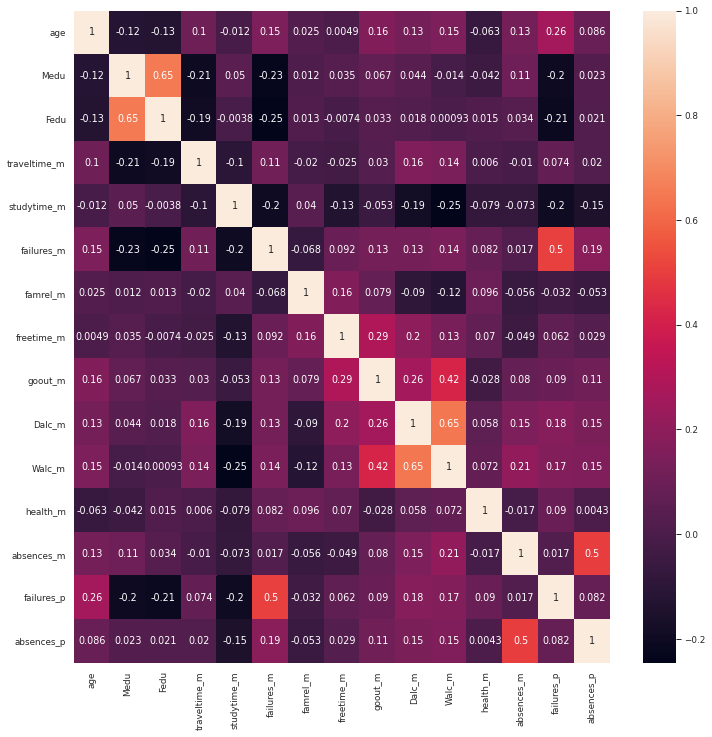

In [260]:
up_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=.1).astype('bool'))
to_drop = [column for column in upper_tri.columns if any(up_tri[column] > 0.93)]

_, ax=plt.subplots(figsize=(12,12))

(sns.heatmap(full_df.drop(columns=to_drop)
             .drop(columns=grade_cols)
             .corr(),
            annot=True)
)

In [261]:
full_df.drop(columns=to_drop,inplace=True)

In [262]:
full_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian_m', 'traveltime_m', 'studytime_m',
       'failures_m', 'schoolsup_m', 'famsup_m', 'paid_m', 'activities_m',
       'nursery', 'higher_m', 'internet', 'romantic_m', 'famrel_m',
       'freetime_m', 'goout_m', 'Dalc_m', 'Walc_m', 'health_m', 'absences_m',
       'G1_m', 'G2_m', 'G3_m', 'guardian_p', 'failures_p', 'schoolsup_p',
       'famsup_p', 'paid_p', 'activities_p', 'higher_p', 'romantic_p',
       'absences_p', 'G1_p', 'G2_p', 'G3_p'],
      dtype='object')

<ipython-input-263-03a795d9e811>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  full_df[grade_cols].hist(ax=ax)


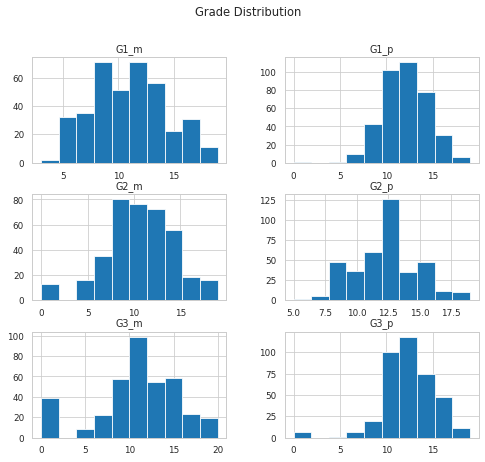

In [263]:
_, ax=plt.subplots(figsize=(8,7))
full_df[grade_cols].hist(ax=ax)
_.suptitle('Grade Distribution');

### For the categorical Variable, we will use the mean grade in math

<ipython-input-264-a36b5e7198b9>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  full_df[['mean_m','mean_p']].hist(ax=ax);


Text(0.5, 0.98, 'Mean grade Distribution')

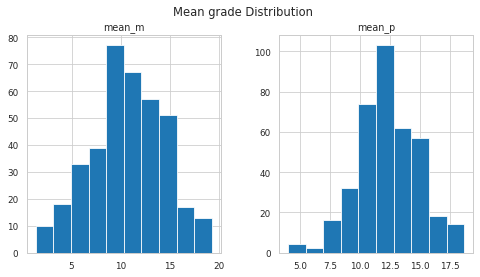

In [264]:
full_df['mean_m'] = full_df[['G1_m','G2_m','G3_m']].mean(axis=1)
full_df['mean_p'] = full_df[['G1_p','G2_p','G3_p']].mean(axis=1)
_, ax=plt.subplots(figsize=(8,4))
full_df[['mean_m','mean_p']].hist(ax=ax);
_.suptitle('Mean grade Distribution')

### Changing Categorical values to category dtype

In [265]:
object_cols = full_df.select_dtypes(['object']).columns
full_df[object_cols] = full_df[object_cols].apply(lambda x: x.astype('category'))
full_df.dtypes[:4]

school     category
sex        category
age           int64
address    category
dtype: object

In [279]:
dep_var = 'mean_m'

def cont_cat_split(df, max_card=20, dep_var=None):
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        
        # mod to detect ProductSize type properly
        if (df[label].dtype.name == 'category'):
            cat_names.append(label)
            continue

        if (np.issubdtype(df[label].dtype, np.integer) and
            df[label].unique().shape[0] > max_card or
            np.issubdtype(df[label].dtype, np.floating)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [280]:
# preparing TabularPandas
procs = [Categorify, FillMissing]
cont,cat=cont_cat_split(full_df,1, dep_var)
splitter = ShuffleSplit(n_splits=1,test_size=0.3)
train_idx, test_idx = next(splitter.split(full_df.index))

In [289]:
split = (list(train_idx), list(test_idx))
len(split)

2

In [290]:
to = TabularPandas(full_df, procs, cat, cont, y_names=dep_var, splits=split)

In [295]:
len(to.train),len(to.valid)

(267, 115)

### Saving TabularPandas for later use

In [297]:
# save_pickle(path/'student_tab.pkl',to)

In [298]:
to = load_pickle(path/'student_tab.pkl')

In [300]:
train_x,train_y = to.train.xs,to.train.y
valid_x,valid_y = to.valid.xs,to.valid.y